# 影像處理練習
- 透過影像處理的步驟，以不進行模型訓練的方式來辨識門牌圖片與手寫字
- 步驟如下：
   1. 讀入門牌圖片
   2. 前處理圖片
   3. 切割圖片
   4. 影像檢索

In [1]:
## 載入套件
import cv2
import matplotlib.pyplot as plt
import numpy as np
import photohash
import math

## Function Definition

### Step 1. 讀入門牌圖片

In [2]:
## 讀檔
def readImage(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    # print('shape: ', img.shape)
    plt.imshow(img, cmap='gray')
    return img


### Step 2. 前處理圖片

In [3]:
## closing 去雜訊，可傳入 kernel 大小
def closing(img, para):
    img_closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, np.ones((para, para)))
    # plt.imshow(img_closing, cmap='gray')
    return img_closing

In [4]:
## opening 去雜訊，可傳入 kernel 大小
def opening(img, para):
    img_opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, np.ones((para, para)))
    # plt.imshow(img_opening, cmap='gray')
    return img_opening

In [5]:
## 裁切圖片，傳入上下左右座標
def crop(img, left, right, up, down):
    x_l, x_r = left, right
    y_u, y_d = up, down
    crop_img = img[y_u:y_d, x_l:x_r]
    # plt.imshow(crop_img, cmap='gray')
    return crop_img


In [6]:
## 旋轉，可傳要旋轉的角度(-順/+逆)
def rotate(img, deg):
    (h, w) = img.shape
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, deg, 1.0)
    rotate_img = cv2.warpAffine(img, M, (w, h))
    # plt.imshow(rotate_img, cmap='gray')
    return rotate_img

In [7]:
## 縮放大小，可傳寬比及高比
def resize(img, wp, hp):
    width = int(img.shape[1] * wp / 100)
    height = int(img.shape[0] * hp / 100)
    dim = (width, height)
    resize_img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    # plt.imshow(resize_img, cmap='gray')
    return resize_img

In [8]:
## 讓圖片變成正方形，旁邊補黑底
def resize_square(img):
    x = img.shape[1]
    y = img.shape[0]
    target = max(x, y)
    BLACK = [0, 0, 0]
    a = (target - x) / 2
    b = (target - y) / 2
    img_square = cv2.copyMakeBorder(img, int(b), int(b), int(a), int(a), cv2.BORDER_CONSTANT, value=BLACK)
    return img_square

In [9]:
## 調整對比度，白的更白、黑的更黑
def modify_bright_contrast(img, bright=0, contrast=-100):
    B = bright / 255.0
    C = contrast / 255.0
    k = math.tan((45 + 44 * C) / 180 * math.pi)
    img_mod = (img - 127.5 * (1 - B)) * k + 127.5 * (1 + B)
    img_mod = np.clip(img_mod, 0, 255).astype(np.uint8)
    return img_mod


### Step 3. 切割圖片

In [10]:
## 畫出邊緣框框
def draw_contours(img, epsilon):
    
    # Detect edges
    ret, binary_img = cv2.threshold(img, 135, 255, 0)

    # Find contours
    contours, hierarchy = cv2.findContours(binary_img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Approximate contours to polygons
    contours_poly = [None] * len(contours)
    bound_rect = [None] * len(contours)
    for i, c in enumerate(contours):
        contours_poly[i] = cv2.approxPolyDP(c, epsilon, True)
        bound_rect[i] = cv2.boundingRect(contours_poly[i])

    # drawing = np.zeros((binary_img.shape[0], binary_img.shape[1], 3), dtype=np.uint8)
    clone = img.copy()

    # Draw polygonal contour + bounding rects
    for cnt in range(len(contours)):
        cv2.rectangle(clone, (int(bound_rect[cnt][0]), int(bound_rect[cnt][1])), (int(bound_rect[cnt][0]+bound_rect[cnt][2]), int(bound_rect[cnt][1]+bound_rect[cnt][3])), (255, 255, 255), 1)
    
    plt.imshow(clone, cmap='gray')
    print(bound_rect)
    return bound_rect


### Step 4. 檢索圖片
使用 hash distance 判別影像之間的相似程度。

In [11]:
## 計算圖片的 hash 值，平均哈希算法
def ahash(img):
    img = cv2.resize(img, (28, 28), interpolation=cv2.INTER_CUBIC)
    s = 0
    ahash_str = ''
    for i in range(img.shape[1]):
        for j in range(img.shape[0]):
            s = s + img[i, j]
    pix = img.shape[1] * img.shape[0]
    avg = s / pix
    for i in range(img.shape[1]):
        for j in range(img.shape[0]):
            if img[i, j] > avg:
                ahash_str = ahash_str + '1'
            else:
                ahash_str = ahash_str + '0'
    result = ''
    for i in range(0, pix, 4):
        result += ''.join('%x' % int(ahash_str[i: i + 4], 2))
    return result


In [12]:
## 計算圖片的 hash 值，差異值哈希算法
def phash(img):
    img = cv2.resize(img, (28, 28), interpolation=cv2.INTER_CUBIC)
    avg = sum([sum(img[i]) for i in range(28)])/784
    str = ''
    for i in range(28):
        str += ''.join(map(lambda i: '0' if i < avg else '1', img[i]))
    pix = img.shape[1] * img.shape[0]
    result = ''
    for i in range(0, pix, 4):
        result += ''.join('%x' % int(str[i: i + 4], 2))
    return result


In [13]:
## 計算圖片的 hash 值，差異值哈希算法
def dhash(img):
    img = cv2.resize(img, (29, 28), interpolation=cv2.INTER_CUBIC)
    dhash_str = ''
    for i in range(28):
        for j in range(28):
            if img[i, j] > img[i, j+1]:
                dhash_str = dhash_str + '1'
            else:
                dhash_str = dhash_str + '0'
    pix = img.shape[1] * img.shape[0]
    result = ''
    for i in range(0, 764, 4):
        result += ''.join('%x' % int(dhash_str[i: i + 4], 2))
    return result


In [14]:
## 計算跟 mnist 資料題中的 hash distance
def count_dist(img, algo):
    similar = 1000000
    similar_img = 10
    for i in range(0, 9):
        ref = readImage('mnist/' + str(i) + '.jpg')
        if algo == 0: 
            hash_one = ahash(img)
            hash_two = ahash(ref)
        elif algo == 1:
            hash_one = phash(img)
            hash_two = phash(ref)
        elif algo == 2:
            hash_one = dhash(img)
            hash_two = dhash(ref)

        distance = photohash.hash_distance(hash_one, hash_two)
        if (distance < similar):
            similar = distance
            similar_img = ref
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title("target")
    plt.subplot(1, 2, 2)
    plt.imshow(similar_img, cmap='gray')
    plt.title("result")

## Experiments

### Case 1.

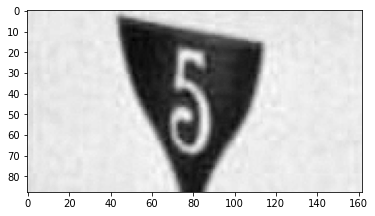

In [15]:
img_1 = readImage("門牌圖片/1.png")

Text(0.5, 1.0, 'after resize')

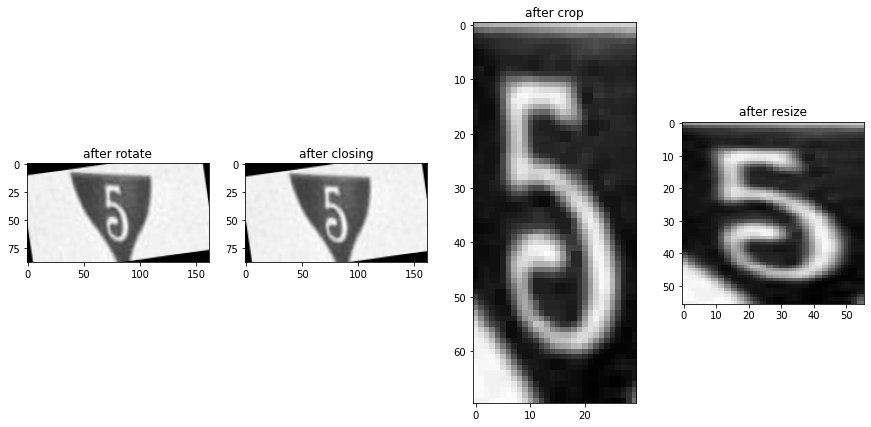

In [16]:
img_rotate_1 = rotate(img_1, 8)
img_closing_1 = closing(img_rotate_1, 2)
img_crop_1 = crop(img_closing_1, 65, 95, 10, 80)
img_resize_1 = resize(img_crop_1, 188, 80)
plt.figure(figsize=(15, 7))
plt.subplot(1, 4, 1)
plt.imshow(img_rotate_1, cmap='gray')
plt.title('after rotate')
plt.subplot(1, 4, 2)
plt.imshow(img_closing_1, cmap='gray')
plt.title('after closing')
plt.subplot(1, 4, 3)
plt.imshow(img_crop_1, cmap='gray')
plt.title('after crop')
plt.subplot(1, 4, 4)
plt.imshow(img_resize_1, cmap='gray')
plt.title('after resize')

(-0.5, 55.5, 55.5, -0.5)

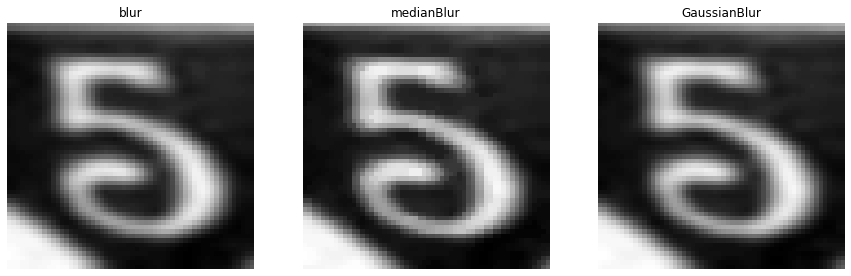

In [17]:
img_blur_1 = cv2.blur(img_resize_1, (3, 3))
img_blur_2 = cv2.medianBlur(img_resize_1, 3)
img_blur_3 = cv2.GaussianBlur(img_resize_1, (3, 3), 0, 0)
plt.figure(figsize=(15, 7))
plt.subplot(1, 3, 1)
plt.imshow(img_blur_1, cmap='gray')
plt.title("blur")
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(img_blur_2, cmap='gray')
plt.title("medianBlur")
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(img_blur_3, cmap='gray')
plt.title("GaussianBlur")
plt.axis('off')

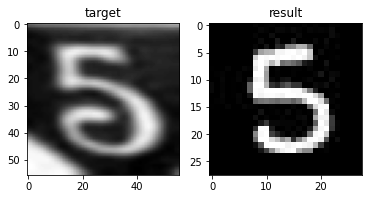

In [18]:
count_dist(img_blur_3, 0)

### Case 2. 

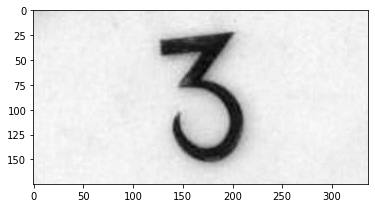

In [19]:
img_2 = readImage('門牌圖片/2.png')

Text(0.5, 1.0, 'after reverse')

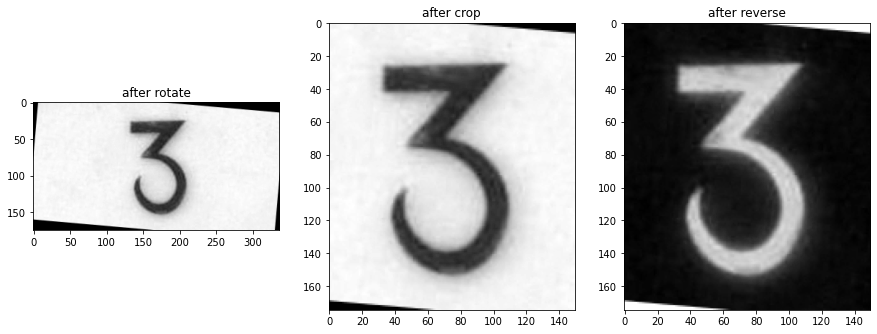

In [20]:
img_rotate_2 = rotate(img_2, -5)
img_crop_2 = crop(img_rotate_2, 100, 250, 0, 200)
img_rev_2 = 255 - img_crop_2
plt.figure(figsize=(15, 7))
plt.subplot(1, 3, 1)
plt.imshow(img_rotate_2, cmap='gray')
plt.title('after rotate')
plt.subplot(1, 3, 2)
plt.imshow(img_crop_2, cmap='gray')
plt.title('after crop')
plt.subplot(1, 3, 3)
plt.imshow(img_rev_2, cmap='gray')
plt.title('after reverse')


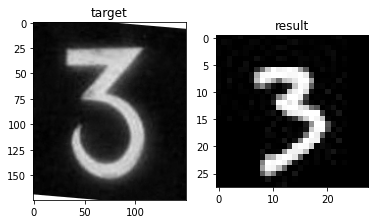

In [21]:
count_dist(img_rev_2, 0)

### Case 3.

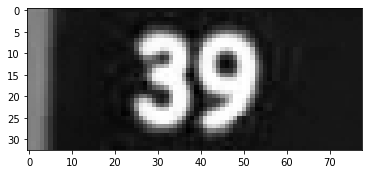

In [22]:
img_3 = readImage("門牌圖片/3.png")

Text(0.5, 1.0, 'after erode')

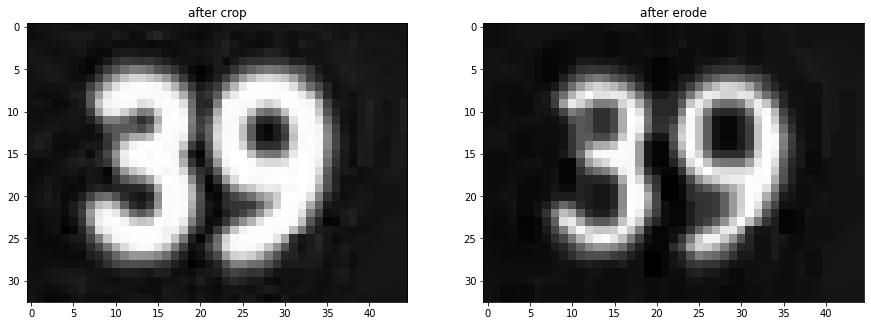

In [23]:
img_crop_3 = crop(img_3, 18, 63, 0, 35)
img_erode_3 = cv2.erode(img_crop_3, np.ones((3, 2)), iterations=1)
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.imshow(img_crop_3, cmap='gray')
plt.title('after crop')
plt.subplot(1, 2, 2)
plt.imshow(img_erode_3, cmap='gray')
plt.title('after erode')

[(23, 6, 13, 22), (8, 6, 12, 21)]


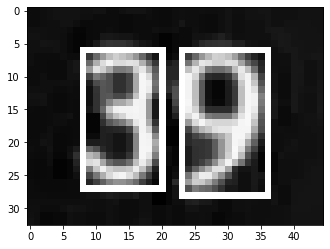

In [24]:
edge_3 = draw_contours(img_erode_3, 5)

(-0.5, 20.5, 21.5, -0.5)

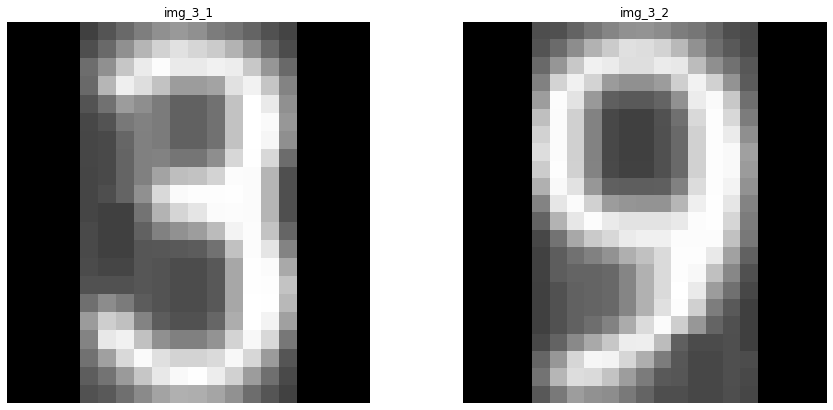

In [25]:
# img_3_1 = img_crop_3[edge_3[1][1]-4:edge_3[1][1]+edge_3[1][3]+4, edge_3[1][0]-6:edge_3[1][0]+edge_3[1][2]]
# img_3_2 = img_crop_3[edge_3[0][1]-4:edge_3[0][1]+edge_3[0][3]+4, edge_3[0][0]:edge_3[0][0]+edge_3[0][2]+6]
img_3_1 = img_erode_3[edge_3[1][1]:edge_3[1][1]+edge_3[1][3], 
                     edge_3[1][0]:edge_3[1][0]+edge_3[1][2]]
img_3_2 = img_erode_3[edge_3[0][1]:edge_3[0][1]+edge_3[0][3], 
                     edge_3[0][0]:edge_3[0][0]+edge_3[0][2]]
img_3_1 = resize_square(img_3_1)
img_3_2 = resize_square(img_3_2)
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.imshow(img_3_1, cmap='gray')
plt.title("img_3_1")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(img_3_2, cmap='gray')
plt.title("img_3_2")
plt.axis('off')


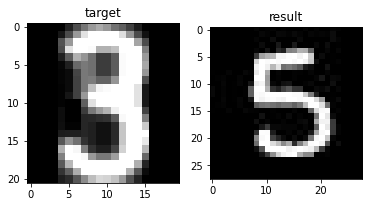

In [26]:
img_3_1_m = modify_bright_contrast(img_3_1, 0, 110)
count_dist(img_3_1_m, 1)

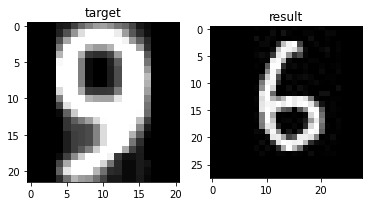

In [27]:
img_3_2_m = modify_bright_contrast(img_3_2, 0, 110)
count_dist(img_3_2_m, 1)

### Case 4.

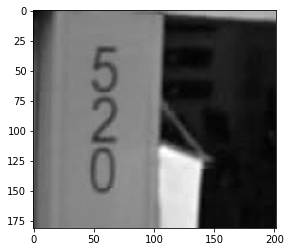

In [28]:
img_4 = readImage("門牌圖片/4.png")

Text(0.5, 1.0, 'after modify contrast')

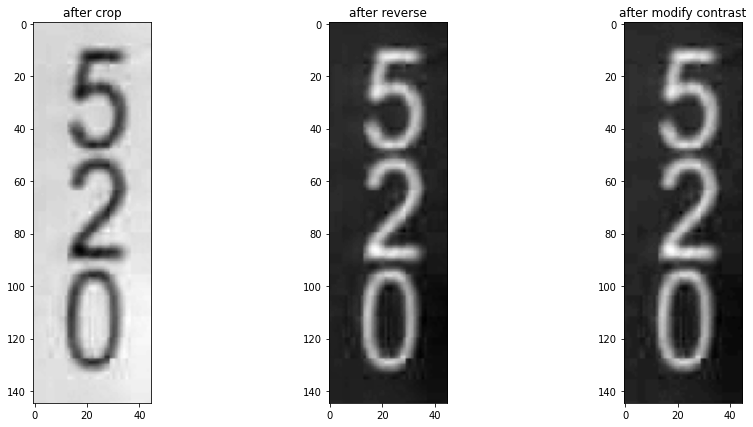

In [29]:
img_crop_4 = crop(img_4, 35, 80, 20, 165)
img_rev_4 = 255 - img_crop_4
# img_dilate_4 = cv2.dilate(img_rev_4, np.ones((1, 5)), iterations=1)
img_BnC_4 = modify_bright_contrast(img_rev_4)
plt.figure(figsize=(15, 7))
plt.subplot(1, 3, 1)
plt.imshow(img_crop_4, cmap='gray')
plt.title('after crop')
plt.subplot(1, 3, 2)
plt.imshow(img_rev_4, cmap='gray')
plt.title('after reverse')
# plt.subplot(1, 4, 3)
# plt.imshow(img_dilate_4, cmap='gray')
# plt.title('after dilate')
plt.subplot(1, 3, 3)
plt.imshow(img_BnC_4, cmap='gray')
plt.title('after modify contrast')

[(13, 94, 20, 39), (15, 52, 20, 39), (13, 10, 23, 39)]


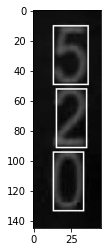

In [30]:
edge_4 = draw_contours(img_BnC_4, 5)

Text(0.5, 1.0, 'img_4_3')

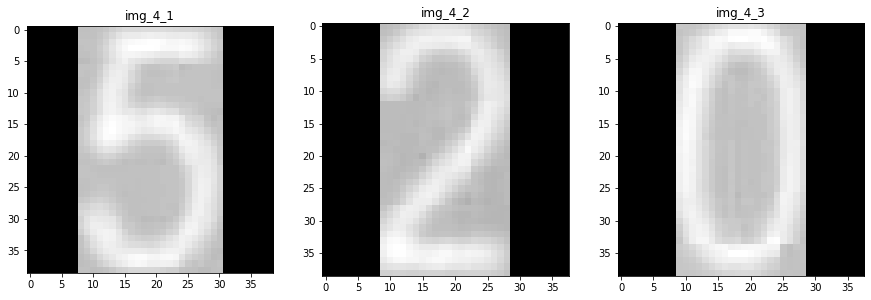

In [31]:
img_4_1 = img_BnC_4[edge_4[2][1]:edge_4[2][1]+edge_4[2][3],
                    edge_4[2][0]:edge_4[2][0]+edge_4[2][2]]
img_4_2 = img_BnC_4[edge_4[1][1]:edge_4[1][1]+edge_4[1][3],
                     edge_4[1][0]:edge_4[1][0]+edge_4[1][2]]
img_4_3 = img_BnC_4[edge_4[0][1]:edge_4[0][1]+edge_4[0][3],
                     edge_4[0][0]:edge_4[0][0]+edge_4[0][2]]
img_4_1 = resize_square(img_4_1)
img_4_2 = resize_square(img_4_2)
img_4_3 = resize_square(img_4_3)
plt.figure(figsize=(15, 7))
plt.subplot(1, 3, 1)
plt.imshow(img_4_1, cmap='gray')
plt.title("img_4_1")
plt.subplot(1, 3, 2)
plt.imshow(img_4_2, cmap='gray')
plt.title("img_4_2")
plt.subplot(1, 3, 3)
plt.imshow(img_4_3, cmap='gray')
plt.title("img_4_3")


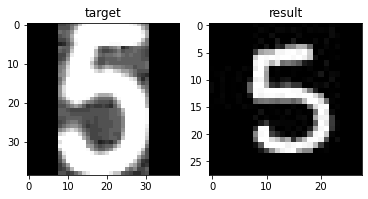

In [32]:
img_4_1_m = modify_bright_contrast(img_4_1, 0, 235)
count_dist(img_4_1_m, 1)

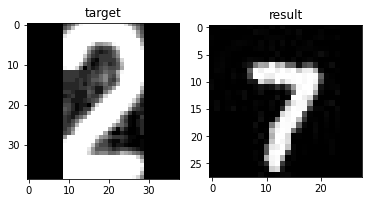

In [33]:
img_4_2_m = modify_bright_contrast(img_4_2, 0, 240)
count_dist(img_4_2_m, 0)


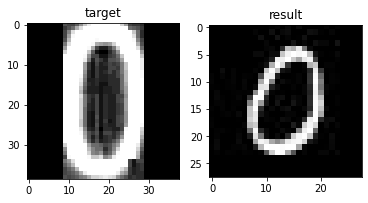

In [34]:
img_4_3_m = modify_bright_contrast(img_4_3, 0, 235)
count_dist(img_4_3_m, 0)

### Case 5.

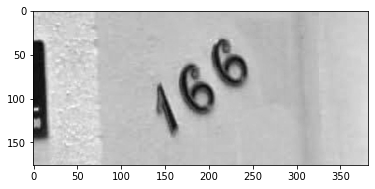

In [35]:
img_5 = readImage('門牌圖片/5.png')

Text(0.5, 1.0, 'after erode')

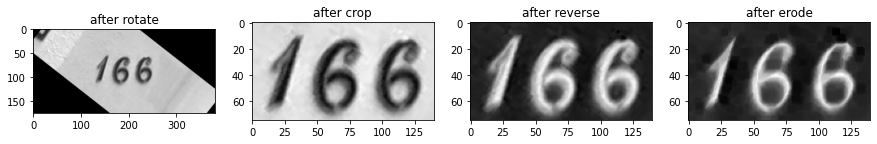

In [36]:
img_rotate_5 = rotate(img_5, -38)
img_crop_5 = crop(img_rotate_5, 120, 260, 45, 120)
img_rev_5 = 255 - img_crop_5
img_erode_5 = cv2.erode(img_rev_5, np.ones((5, 5)))
plt.figure(figsize=(15, 7))
plt.subplot(1, 4, 1)
plt.imshow(img_rotate_5, cmap='gray')
plt.title('after rotate')
plt.subplot(1, 4, 2)
plt.imshow(img_crop_5, cmap='gray')
plt.title('after crop')
plt.subplot(1, 4, 3)
plt.imshow(img_rev_5, cmap='gray')
plt.title('after reverse')
plt.subplot(1, 4, 4)
plt.imshow(img_erode_5, cmap='gray')
plt.title('after erode')


[(97, 16, 31, 52), (49, 15, 31, 55), (15, 13, 21, 51)]


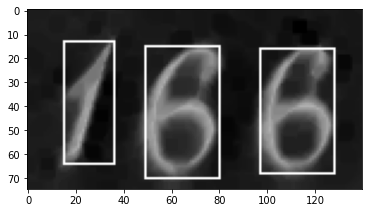

In [37]:
edge_5 = draw_contours(img_erode_5, 3)

Text(0.5, 1.0, 'img_5_3')

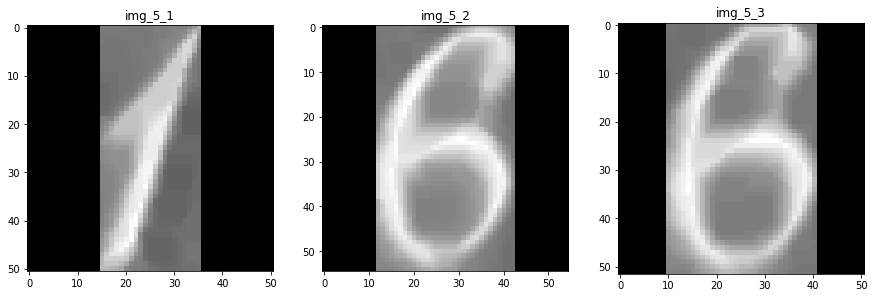

In [38]:
img_5_1 = img_erode_5[edge_5[2][1]:edge_5[2][1]+edge_5[2][3],
                    edge_5[2][0]:edge_5[2][0]+edge_5[2][2]]
img_5_2 = img_erode_5[edge_5[1][1]:edge_5[1][1]+edge_5[1][3],
                    edge_5[1][0]:edge_5[1][0]+edge_5[1][2]]
img_5_3 = img_erode_5[edge_5[0][1]:edge_5[0][1]+edge_5[0][3],
                    edge_5[0][0]:edge_5[0][0]+edge_5[0][2]]
img_5_1 = resize_square(img_5_1)
img_5_2 = resize_square(img_5_2)
img_5_3 = resize_square(img_5_3)
plt.figure(figsize=(15, 7))
plt.subplot(1, 3, 1)
plt.imshow(img_5_1, cmap='gray')
plt.title("img_5_1")
plt.subplot(1, 3, 2)
plt.imshow(img_5_2, cmap='gray')
plt.title("img_5_2")
plt.subplot(1, 3, 3)
plt.imshow(img_5_3, cmap='gray')
plt.title("img_5_3")

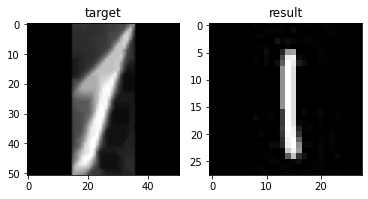

In [39]:
img_5_1_m = modify_bright_contrast(img_5_1, 0, 120)
count_dist(img_5_1_m, 2)

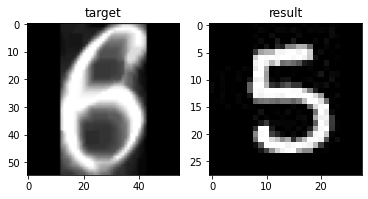

In [56]:
img_5_2_m = modify_bright_contrast(img_5_2, 0, 150)
count_dist(img_5_2_m, 1)

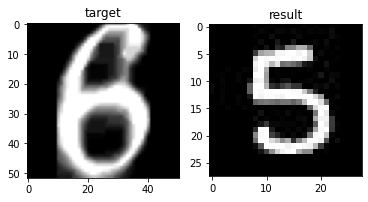

In [57]:
img_5_3_m = modify_bright_contrast(img_5_3, 0, 180)
count_dist(img_5_3_m, 0)